In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np


import os
import cv2
import sys
import h5py
import time
import pickle
import tempfile
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display as ipy_display, clear_output

In [2]:
# setting path
sys.path.append('../')

In [3]:
deplabv3 = __import__('Deeplabv3')
import networks

In [4]:
dataset = __import__('dataset-step4')

# parameters

In [5]:
num_classes = 5
batch_size = 1
suffix = 'run4'
epoch = 126
epoch = str(epoch)

dataset_name = 'abdomen'

# CUDA

In [6]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

# Path

In [7]:
root = "/scratch/rs37890/CARC/Medical_images_source_MR/data/data/"

In [8]:
source_mr_train_dir = root + "h5py/"
source_mr_test_dir = root + "h5py/"

In [9]:
target_ct_train_dir = root + "h5py/"
target_ct_test_dir = root + "h5py/"

# label_ids_abdomen

In [10]:
label_ids_abdomen = {"ignore": 0,
    "lv_myo": 1,
    "la_blood": 2,
    "lv_blood": 3,
    "aa": 4,
}
label_ids = label_ids_abdomen

# Dataset

In [11]:
def sample_batch(dataset, batch_size=20, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    data_dir = dataset.data_dir
    num_samples = len(dataset)
    sample_indices = np.random.choice(num_samples, batch_size, replace=False) # replace=True allow repeat

    images = []
    labels = []

    for idx in sample_indices:
        
        data_vol, label_vol = dataset[idx]
        
        images.append(data_vol)
        labels.append(label_vol)

    images = torch.stack(images)
    labels = torch.stack(labels)

    return images, labels

#  sliding_window

In [12]:
def sliding_window(input_volume, window_size=(32, 32, 32), stride=(16, 16, 16)):
    
    z_max = input_volume.shape[0] - window_size[0] + 1
    x_max = input_volume.shape[1] - window_size[1] + 1
    y_max = input_volume.shape[2] - window_size[2] + 1

    windows = []

    for y in range(0, y_max, stride[2]):
        for x in range(0, x_max, stride[1]):
            for z in range(0, z_max, stride[0]):
                window = input_volume[z:z+window_size[0], x:x+window_size[1], y:y+window_size[2]]
                windows.append(window)

            # z_remaining
            z_remaining = input_volume.shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
            window = input_volume[z_remaining:, x:x+window_size[1], y:y+window_size[2]]
            windows.append(window)
        
        # x_remaining
        x_remaining = input_volume.shape[1] - window_size[1] # z_remaining = 78 - 32 = 46
        for z in range(0, z_max, stride[0]):
            window = input_volume[z:z+window_size[0], x_remaining: , y:y+window_size[2]]
            windows.append(window)
            
        # x_remaining z_remaining
        z_remaining = input_volume.shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
        window = input_volume[z_remaining:, x_remaining: , y:y+window_size[2]]
        windows.append(window)
    
    # y_remaining
    y_remaining = input_volume.shape[2] - window_size[2] # z_remaining = 78 - 32 = 46
    for x in range(0, x_max, stride[1]):
        for z in range(0, z_max, stride[0]):
            window = input_volume[z:z+window_size[0], x:x+window_size[1], y_remaining: ]
            windows.append(window)
            
        # y_remaining z_remaining
        z_remaining = input_volume.shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
        window = input_volume[z_remaining:, x:x+window_size[1], y_remaining:]
        windows.append(window)

    # y_remaining x_remaining
    x_remaining = input_volume.shape[1] - window_size[1] # z_remaining = 78 - 32 = 46
    for z in range(0, z_max, stride[0]):
        window = input_volume[z:z+window_size[0], x_remaining: , y_remaining:]
        windows.append(window)

    # y_remaining x_remaining z_remaining
    z_remaining = input_volume.shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
    window = input_volume[z_remaining:, x_remaining: , y_remaining:]
    windows.append(window)

    return windows

In [13]:
def combine_windows(window_outputs, input_volume_shape, window_size=(32, 32, 32), stride=(16, 16, 16)):
    num_classes = window_outputs[0].shape[1] # 5
    combined_prob = torch.zeros((num_classes,) + input_volume_shape).to(device)
    count_matrix = torch.zeros(input_volume_shape).to(device)

    z_max = input_volume_shape[0] - window_size[0] + 1
    x_max = input_volume_shape[1] - window_size[1] + 1
    y_max = input_volume_shape[2] - window_size[2] + 1

    idx = 0
    
    
    for y in range(0, y_max, stride[2]):
        for x in range(0, x_max, stride[1]):
            for z in range(0, z_max, stride[0]):
                output = window_outputs[idx].squeeze() # output.cpu().numpy().shape: (5, 32, 256, 256)
                combined_prob[:, z:z+window_size[0], x:x+window_size[1], y:y+window_size[2]] += output
                count_matrix[z:z+window_size[0], x:x+window_size[1], y:y+window_size[2]] += 1
                idx += 1
                

            # z_remaining
            z_remaining = input_volume_shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
            output = window_outputs[idx].squeeze()
            combined_prob[:, z_remaining:, x:x+window_size[1], y:y+window_size[2]] += output
            count_matrix[z_remaining:, x:x+window_size[1], y:y+window_size[2]] += 1
            idx += 1
        
        # x_remaining
        x_remaining = input_volume_shape[1] - window_size[1] # z_remaining = 78 - 32 = 46
        for z in range(0, z_max, stride[0]):
            output = window_outputs[idx].squeeze()
            combined_prob[:, z:z+window_size[0], x_remaining: , y:y+window_size[2]] += output
            count_matrix[z:z+window_size[0], x_remaining: , y:y+window_size[2]] += 1
            idx += 1
            
            
        # x_remaining z_remaining
        z_remaining = input_volume_shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
        output = window_outputs[idx].squeeze()
        combined_prob[:, z_remaining:, x_remaining: , y:y+window_size[2]] += output
        count_matrix[z_remaining:, x_remaining: , y:y+window_size[2]] += 1
        idx += 1
        
    
    # y_remaining
    y_remaining = input_volume_shape[2] - window_size[2] # z_remaining = 78 - 32 = 46
    for x in range(0, x_max, stride[1]):
        for z in range(0, z_max, stride[0]):
            output = window_outputs[idx].squeeze()
            combined_prob[:, z:z+window_size[0], x:x+window_size[1], y_remaining: ] += output
            count_matrix[z:z+window_size[0], x:x+window_size[1], y_remaining: ] += 1
            idx += 1
            
            
        # y_remaining z_remaining
        z_remaining = input_volume_shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
        output = window_outputs[idx].squeeze()
        combined_prob[:, z_remaining:, x:x+window_size[1], y_remaining:] += output
        count_matrix[z_remaining:, x:x+window_size[1], y_remaining:] += 1
        idx += 1
        

    # y_remaining x_remaining
    x_remaining = input_volume_shape[1] - window_size[1] # z_remaining = 78 - 32 = 46
    for z in range(0, z_max, stride[0]):
        output = window_outputs[idx].squeeze()
        combined_prob[:, z:z+window_size[0], x_remaining: , y_remaining:] += output
        count_matrix[z:z+window_size[0], x_remaining: , y_remaining:] += 1
        idx += 1

    # y_remaining x_remaining z_remaining
    z_remaining = input_volume_shape[0] - window_size[0] # z_remaining = 78 - 32 = 46
    output = window_outputs[idx].squeeze()
    combined_prob[:, z_remaining:, x_remaining: , y_remaining:] += output
    count_matrix[z_remaining:, x_remaining: , y_remaining:] += 1
    idx += 1
    
    
    # Normalize the class probabilities
    combined_prob /= count_matrix

    # Take the argmax of the accumulated probabilities
    combined_output = torch.argmax(combined_prob, dim=0)

    return combined_output

# Initialize

In [14]:
dataloader = dataset.get_dataloader( target_ct_train_dir,  target_ct_test_dir, num_classes, batch_size,  domain = 'target' )

train_dataset = dataloader["train"].dataset
#test_dataset = train_dataset
test_dataset = dataloader["test"].dataset

In [15]:
dpv3 = deplabv3.DeepLabV3(num_classes)
classifier = networks.classifier(num_classes)

dpv3 = dpv3.to(device)
classifier = classifier.to(device)

# parallel
dpv3 = torch.nn.DataParallel(dpv3)
classifier = torch.nn.DataParallel(classifier)

In [16]:
dpv3_checkpoint = torch.load('/scratch/rs37890/CARC/Medical_images_source_MR/Deeplabv3_source_MR/record-data/dpv3_weights_20000.pth')
classifier_checkpoint = torch.load('/scratch/rs37890/CARC/Medical_images_source_MR/Deeplabv3_source_MR/record-data/classifier_weights_20000.pth')

dpv3.load_state_dict(dpv3_checkpoint)
classifier.load_state_dict(classifier_checkpoint)
print("continue_run")
print("Loaded model weights")

continue_run
Loaded model weights


In [17]:
dpv3 = dpv3.module
classifier = classifier.module

In [18]:
with open('Adaptation-record-data/' + "target_test_DICE_history"  + ".pkl", "rb") as file:
    target_test_DICE_history = pickle.load(file)
    
print(len(target_test_DICE_history))

155


In [19]:
max_dice_score = 0
max_idx = 0
for idx, dice_score in enumerate(target_test_DICE_history):

    if dice_score > max_dice_score:
        max_dice_score = dice_score
        max_idx = idx

In [20]:
max_idx

126

# Show results

In [21]:
test_output = []

for img_idx in range(len(test_dataset)): # 0, 1, 2, 3
    
    data_vol, label_vol = test_dataset[img_idx] # data_vol: torch.Size([1, 60, 512, 512])
    data_vol = data_vol.to(device)
    label_vol = label_vol.to(device)
    
    data_vol = torch.squeeze(data_vol, 0) # data_vol:  torch.Size([60, 512, 512])
    windows = sliding_window(data_vol) # slice 3D image based on window size and stride
    
    
    
    window_outputs = []
    
    dpv3.eval()
    classifier.eval() 
    with torch.no_grad():
        for window in windows:
            window = window.unsqueeze(0)  # Add a channel dimension: torch.Size([1, 32, 256, 256])
            window = torch.unsqueeze(window, 0)  # Add a batch dimension: torch.Size([1, 1, 32, 256, 256])
            
            # inference
            output = dpv3(window)
            output = classifier(output) # torch.Size([1, 5, 32, 256, 256])
            
            # collect outputs
            window_outputs.append(output)  # len(window_outputs) = 27
            # window_outputs[0].cpu().numpy().shape： (1, 5, 32, 256, 256)

    combined_output = combine_windows(window_outputs, data_vol.size())
    test_output.append(combined_output)

/home/rs37890/.conda/envs/diffusion/lib/python3.9/site-packages/torch/nn/modules/conv.py:605: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400441250/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(


# evaluate

In [22]:
numpy_arrays = [tensor.cpu().numpy() for tensor in test_output]

In [23]:
numpy_arrays[0].shape

(99, 102, 104)

In [24]:
numpy_arrays[1].shape

(109, 121, 84)

In [25]:
numpy_arrays[2].shape

(159, 87, 86)

In [26]:
numpy_arrays[3].shape

(124, 101, 117)

In [27]:
id_to_ignore = 0
intersection = dict()
total = dict()
for label in label_ids:
    intersection[label] = total[label] = 0



for img_idx in range(len(test_dataset)): # 0, 1, 2, 3

    # if img_idx != 3:
    #     continue
    
    data_sample, y_true = test_dataset[img_idx] # data_vol: torch.Size([1, 60, 512, 512])
    
    y_hat = numpy_arrays[img_idx]
    data_sample = data_sample.cpu().numpy() 
    y_true = y_true.cpu().numpy() 
    
    print(y_hat.shape)
    print(y_true.shape)
    
    for label in label_ids:
        if label_ids[label] == id_to_ignore:
            continue

        curr_id = label_ids[label]

        idx_gt = y_true == curr_id
        idx_hat = y_hat == curr_id

        intersection[label] += 2 * np.sum(idx_gt & idx_hat)
        total[label] += np.sum(idx_gt) + np.sum(idx_hat)
        
        
dice = []
res = dict()
for label in label_ids:
    if label_ids[label] == id_to_ignore:
        continue

    if total[label] != 0:
        res[label] = intersection[label] / total[label]
    else:
        print('total is zero')
        res[label] = np.float64(0)

    dice.append(res[label])

(99, 102, 104)
(99, 102, 104)
(109, 121, 84)
(109, 121, 84)
(159, 87, 86)
(159, 87, 86)
(124, 101, 117)
(124, 101, 117)


In [28]:
np.mean(dice)

0.6680990337808693

In [29]:
for k in res:
    print(k, res[k])

lv_myo 0.2838946185238329
la_blood 0.7915568516756858
lv_blood 0.7471126397034586
aa 0.8498320252204999


In [30]:
img_idx = 3

In [31]:
data_sample = data_sample[0]

# data sample slice

Shape: (124, 101), Data Type: float32


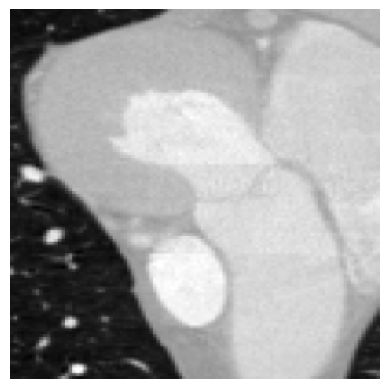

In [32]:
z_slice = int(data_sample.shape[2] / 2)
slice_img = data_sample[:, :, z_slice]

# Check if the slice_img is empty or not
if slice_img.size == 0:
    print("The image slice is empty. Check your slicing indices.")
else:
    print(f"Shape: {slice_img.shape}, Data Type: {slice_img.dtype}")

    # Convert to a suitable type if necessary
    if slice_img.dtype != np.uint8:
        slice_img = (255 * (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min())).astype(np.uint8)

    # Define the new size you want for the square image
    square_size = 256

    # Resize the image to square
    square_img = cv2.resize(slice_img, (square_size, square_size), interpolation=cv2.INTER_AREA)

    # Plot the image
    plt.imshow(square_img, cmap='gray')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    # plt.imsave(f'The_data_{img_idx}.png', square_img, cmap='gray')

In [33]:
y_hat.shape

(124, 101, 117)

Shape: (124, 101), Data Type: int64


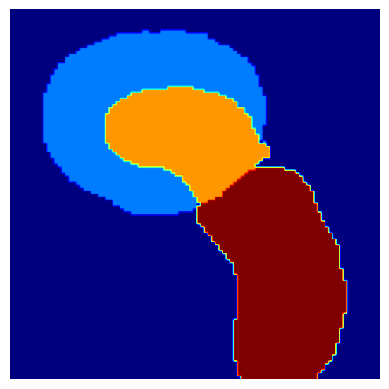

In [34]:
z_slice = int(y_true.shape[2] / 2)
slice_img = y_true[:, :, z_slice]

# Check if the slice_img is empty or not
if slice_img.size == 0:
    print("The image slice is empty. Check your slicing indices.")
else:
    print(f"Shape: {slice_img.shape}, Data Type: {slice_img.dtype}")

    # Convert to a suitable type if necessary
    if slice_img.dtype != np.uint8:
        slice_img = (255 * (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min())).astype(np.uint8)

    # Define the new size you want for the square image
    square_size = 256

    # Resize the image to square
    square_img = cv2.resize(slice_img, (square_size, square_size), interpolation=cv2.INTER_AREA)

    # Plot the image
    plt.imshow(square_img, cmap='jet')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

    # plt.imsave(f'The_labels_{img_idx}.png', square_img, cmap='jet')

In [35]:
# z_slice = int(y_hat.shape[2] / 2)
# slice_img = y_hat[:, :, z_slice]

# # Check if the slice_img is empty or not
# if slice_img.size == 0:
#     print("The image slice is empty. Check your slicing indices.")
# else:
#     print(f"Shape: {slice_img.shape}, Data Type: {slice_img.dtype}")

#     # Convert to a suitable type if necessary
#     if slice_img.dtype != np.uint8:
#         slice_img = (255 * (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min())).astype(np.uint8)

#     # Define the new size you want for the square image
#     square_size = 256

#     # Resize the image to square
#     square_img = cv2.resize(slice_img, (square_size, square_size), interpolation=cv2.INTER_AREA)

#     # Plot the image
#     plt.imshow(square_img, cmap='jet')
#     plt.axis('off')  # Turn off axis numbers and ticks
#     plt.show()

#     plt.imsave(f'Pre-Adapt_{img_idx}.png', square_img, cmap='jet')